<br><center><h1 style="font-size:2em"> Yelp Data Analysis</h1></center>
<br>
<br> **Zeinab Gaeini**

The Yelp dataset is a collection of data provided by Yelp, an online platform that allows users to discover and review businesses, particularly those in the restaurant and hospitality industry. The dataset includes a diverse set of information related to businesses, user reviews, user profiles, and more. Here's a brief overview of the key components of the Yelp dataset:

- **Review Data**: User-generated reviews for businesses on Yelp.
Includes information such as user ID, business ID, review text, user ratings, and the time the review was posted.

- **User Data**: User profiles and activity on Yelp. 
Includes details such as user ID, name, review count, friend connections, and the date the user joined Yelp.

- **Business Data**: Information about various businesses listed on Yelp.
Includes details such as business ID, name, location (address, city, state, postal code), categories, and overall rating.

In this project, our goal is to delve into the dataset through the integration of tables and statistical analysis to provide an answer for a research question. While numerous evaluations can be conducted on this extensive dataset, we have narrowed our focus to address one specific question.

**Data Source**: https://www.yelp.com/dataset/download

In [771]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
import geopandas as gpd
from shapely.geometry import Point
from transformers import pipeline
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from pyabsa import ATEPCCheckpointManager
from pyabsa import available_checkpoints
import warnings 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: Exploring the dataset

## 1.1. Reading and Storing data
In this step, we read each table and save them as individual dataframes. Initially stored as JSON, the process became time-consuming during kernel restarts. To address this, I've stored the data as a CSV file for faster retrieval. 

### 1.1.1. Review Table

**User-generated reviews for businesses on Yelp.**

**Importing data**

In [ ]:
#read json file of 'reviews' and store it as a data frame 

# Initialize an empty list to store individual JSON objects
data_list = []

# Open the file and read JSON lines
with open('yelp_academic_dataset_review.json', 'r') as file:
    for line in file:
        try:
            # Attempt to load the JSON from each line
            data = json.loads(line)
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Convert the list of JSON objects to a DataFrame
review = pd.DataFrame(data_list)
review.to_csv('yelp_academic_dataset_review.csv', index=False)

**Save it as a CSV file for saving the runnig time**

In [92]:
review = pd.read_csv('yelp_academic_dataset_review.csv')

**Quick look into dataset**

In [825]:
#explor the variables of dataset
review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,date_format
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0.0,0.0,0.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1.0,0.0,1.0,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,2012-01-03 15:28:18


In [760]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990282 entries, 0 to 6990281
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        float64       
 4   useful       float64       
 5   funny        float64       
 6   cool         float64       
 7   text         object        
 8   date         object        
 9   date_format  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 533.3+ MB


In [7]:
#number of rows
len(review)

6990282

**Is there any null values in each column?**

In [58]:
review.isna().mean()

review_id      0.0
user_id        0.0
business_id    0.0
stars          0.0
useful         0.0
funny          0.0
cool           0.0
text           0.0
date           0.0
dtype: float64

**Now we have these information:**
- We have about 7 million rows of data
- No missing values in this table.
- String: user ID and business ID
- Text: review text
- Numeric: user ratings (stars)
- Other numerics: rating attributes (useful, funny, cool)
- Date: Date and time the review was posted

According to the info table, we need to change the format of date variable from string to datatime for further analysis.

In [93]:
# change the format of str to date
review['date_format'] = pd.to_datetime(review.date)

### 1.1.2. User Table

**User profiles and activity on Yelp**

**Importing data**

In [3]:
#read json file of 'user' and store it as a data frame

# Initialize an empty list to store individual JSON objects
data_list = []

# Open the file and read JSON lines
with open('yelp_academic_dataset_user.json', 'r') as file:
    for line in file:
        try:
            # Attempt to load the JSON from each line
            data = json.loads(line)
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Convert the list of JSON objects to a DataFrame
user = pd.DataFrame(data_list)
user.to_csv('yelp_academic_dataset_user.csv', index=False)

**Saving the file as csv for faster loading**

In [94]:
user = pd.read_csv('yelp_academic_dataset_user.csv')

**Look into data table**

In [823]:
pd.set_option('display.max_colwidth', 50)

In [824]:
user.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,date_format_yelping
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,55,56,18,232,844,467,467,239,180,2007-01-25 16:47:26
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,184,157,251,1847,7054,3131,3131,1521,1946,2009-01-25 04:35:42


In [334]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 24 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              object        
 1   name                 object        
 2   review_count         int64         
 3   yelping_since        object        
 4   useful               int64         
 5   funny                int64         
 6   cool                 int64         
 7   elite                object        
 8   friends              object        
 9   fans                 int64         
 10  average_stars        float64       
 11  compliment_hot       int64         
 12  compliment_more      int64         
 13  compliment_profile   int64         
 14  compliment_cute      int64         
 15  compliment_list      int64         
 16  compliment_note      int64         
 17  compliment_plain     int64         
 18  compliment_cool      int64         
 19  compliment_funny     

In [12]:
len(user)

1987897

**Any Null?**

In [353]:
user.isna().mean().round(2)

user_id                0.00
name                   0.00
review_count           0.00
yelping_since          0.00
useful                 0.00
funny                  0.00
cool                   0.00
elite                  0.95
friends                0.44
fans                   0.00
average_stars          0.00
compliment_hot         0.00
compliment_more        0.00
compliment_profile     0.00
compliment_cute        0.00
compliment_list        0.00
compliment_note        0.00
compliment_plain       0.00
compliment_cool        0.00
compliment_funny       0.00
compliment_writer      0.00
compliment_photos      0.00
date_format_yelping    0.00
year_yelping           0.00
dtype: float64

In [95]:
# change the format of str to date
user['date_format_yelping'] = pd.to_datetime(user.yelping_since)

**Now we have this information about user dataset:**
- We have about 2 million rows of data
- Missing values in the "elite" and "friends" columns in the users table
- String: user_id, name
- Numeric: review_count and average_stars
- Date: yelping_since 
- Other variables: 
    - useful, funny, cool: The number of related votes the user has received from other users.
    - elite: Indicates whether the user is part of the Yelp Elite Squad. This variable may contain the year(s) the user achieved elite status.
    - friends: A list of user_ids of friends the user has on Yelp.
    - fans: The number of users who have marked this user as a fan.
    - compliment variables: The number of compliments the user has received for the related content.


### 1.1.3. Exploring Business table

**Information about various businesses listed on Yelp.**

**Reading data**

In [3]:
#read json file of 'business' and store it as a data frame

# Initialize an empty list to store individual JSON objects
data_list = []

# Open the file and read JSON lines
with open('yelp_academic_dataset_business.json', 'r') as file:
    for line in file:
        try:
            # Attempt to load the JSON from each line
            data = json.loads(line)
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Convert the list of JSON objects to a DataFrame
business = pd.DataFrame(data_list)
business.to_csv('yelp_academic_dataset_business.csv', index=False)

**Saving the file a csv for faster loading**

In [96]:
business = pd.read_csv('yelp_academic_dataset_business.csv')

**looking into dataset**

In [826]:
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [386]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   business_id     150346 non-null  object 
 1   name            150346 non-null  object 
 2   address         145219 non-null  object 
 3   city            150346 non-null  object 
 4   state           150346 non-null  object 
 5   postal_code     150273 non-null  object 
 6   latitude        150346 non-null  float64
 7   longitude       150346 non-null  float64
 8   stars           150346 non-null  float64
 9   review_count    150346 non-null  int64  
 10  is_open         150346 non-null  int64  
 11  attributes      136602 non-null  object 
 12  categories      150243 non-null  object 
 13  hours           127123 non-null  object 
 14  new_categories  150346 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 17.2+ MB


In [132]:
len(business)

150346

**Any missing value?**

In [429]:
business.isna().mean().round(2)

business_id       0.00
name              0.00
address           0.03
city              0.00
state             0.00
postal_code       0.00
latitude          0.00
longitude         0.00
stars             0.00
review_count      0.00
is_open           0.00
attributes        0.09
categories        0.00
hours             0.15
new_categories    0.00
dtype: float64

**Now we have this information about business dataset:**

- We have about 150 thousand rows of data
- There are some null values for businesses, including 3% of addresses, 9% of attributes, and 15% of hours are missing. 
- String: business_id, name, address, city, state, postal_code 
- Numeric: latitude, longitude, review_count, and stars
- Boolean: is_open (open: 1, close: 0)
- Other variables:
    - Attributes: A collection of business-specific features or characteristics such as whether a business offers Wi-Fi, accepts credit cards, has outdoor seating, etc.
    - Categories: The categorization of the business into one or more predefined groups or types such as "Restaurants," "Coffee Shops," "Hair Salons," etc.
    - Hours: Information about the operating hours of the business.

# Step 2: Merging tables and create a new dataframe

In this step, I integrated these datasets to facilitate a comprehensive data analysis. **Business_id** and **user_id** are the common features.


In [97]:
# Create a new dataframe with required variables of user table 
user_new = user[['user_id','name','review_count','date_format_yelping','average_stars']]

In [98]:
# Create a new dataframe with required variables of review table 
review_new = review[['review_id','user_id','business_id','stars','text','date_format']]

In [99]:
# Merge business and review table based on business_id
review_business = pd.merge(review_new, business, on='business_id')

In [100]:
review_business = review_business.rename(columns={'stars_x': 'stars_review', 'stars_y': 'stars_business'})

In [143]:
# Merge business with two other tables and create the final dataframe
yelp = pd.merge(review_business, user_new, on = 'user_id')

In [144]:
# Rename columns with similar tags
yelp = yelp.rename(columns={'name_x': 'name_business', 'review_count_x': 'review_count_business',
                            'name_y': 'name_user', 'review_count_y': 'review_count_user',
                           'date': 'date_review'})

**Let's take a look at our new dataframe, yelp**

In [829]:
yelp.head(5)

,review_id,user_id,business_id,stars_review,text,date_format,name_business,address,city,state,...,is_open,attributes,categories,hours,name_user,review_count_user,date_format_yelping,average_stars,day_of_week,month
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,...,1,"{'NoiseLevel': ""u'average'"", 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...",Melanie,33,2016-01-13 17:20:44,4.06,Saturday,July
1,Bqn8psEmvYTO7izrnGNgqg,mh_-eMZ6K5RLWhZyISBhwA,8eDkw7CE0NKqMknPIu26fw,5.0,We tried this place on our first trip to New O...,2018-04-25 17:04:09,Two Chicks Cafe,"901 Convention Center Blvd, Ste 109",New Orleans,LA,...,1,"{'Ambience': ""{'touristy': False, 'hipster': T...","Breakfast & Brunch, Juice Bars & Smoothies, Re...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '...",Melanie,33,2016-01-13 17:20:44,4.06,Wednesday,April
2,PBIeDysdBxwY53IFnOPyUw,mh_-eMZ6K5RLWhZyISBhwA,d_tRshM-w6S4QxE4VVi8tQ,3.0,"Jones is definitely average quality, not many ...",2017-03-05 14:26:14,Jones,700 Chestnut St,Philadelphia,PA,...,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","American (New), Restaurants, Southern, Diners,...","{'Monday': '16:0-21:0', 'Tuesday': '16:0-21:0'...",Melanie,33,2016-01-13 17:20:44,4.06,Sunday,March
3,78MWkzX8uQz0kDnhlhwAAg,mh_-eMZ6K5RLWhZyISBhwA,mOk3D7VczrDapNuUgLxUQw,4.0,So glad we stumbled upon this restaurant! It i...,2018-10-29 21:54:59,Noodle Eighty Eight,664 E Broad St,Souderton,PA,...,1,"{'BikeParking': 'False', 'Alcohol': ""u'none'"",...","Asian Fusion, Noodles, Restaurants, Pan Asian,...","{'Monday': '11:0-21:0', 'Wednesday': '11:30-20...",Melanie,33,2016-01-13 17:20:44,4.06,Monday,October
4,krpCZHUj222Ha7AffGUZHQ,mh_-eMZ6K5RLWhZyISBhwA,L4kfcADLCU4T33i7Z0CkuA,2.0,I was looking forward to a romantic dinner her...,2018-02-11 03:07:30,Bistro Romano,120 Lombard St,Philadelphia,PA,...,1,"{'RestaurantsAttire': ""u'dressy'"", 'Restaurant...","Restaurants, Bars, Wine Bars, Mediterranean, I...","{'Monday': '0:0-0:0', 'Tuesday': '15:0-1:0', '...",Melanie,33,2016-01-13 17:20:44,4.06,Sunday,February


In [145]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990247 entries, 0 to 6990246
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   review_id              object        
 1   user_id                object        
 2   business_id            object        
 3   stars_review           float64       
 4   text                   object        
 5   date_format            datetime64[ns]
 6   name_business          object        
 7   address                object        
 8   city                   object        
 9   state                  object        
 10  postal_code            object        
 11  latitude               float64       
 12  longitude              float64       
 13  stars_business         float64       
 14  review_count_business  int64         
 15  is_open                int64         
 16  attributes             object        
 17  categories             object        
 18  hours                 

# Step 3. Exploratory Data Analysis (EDA) 

In this section, I have systematically categorized variables based on their types and applications, facilitating a comprehensive data analysis. The distinct categories are as follows:

- **Distribution of Stars**: Encompassing business stars, review stars, and average stars per user.

- **Temporal Analysis**: Including variables related to the date of reviews and the duration since a user started using Yelp.

- **Text Analysis**: Focused on variables associated with textual data.

- **Review Count Analysis**: Covering counts related to both users and businesses.

- **Geographical Insights**: Encompassing state, city, latitude, and longitude information.

- **Attributes and Categories Analysis**: Incorporating data related to various attributes and categories associated with businesses.

- **Correlation Analysis**:Investigate correlations between different variables, such as review counts and star ratings. 

This structured approach allows for a more detailed exploration and interpretation of the dataset, providing valuable insights into each aspect of the data.


## 3.1. Know more about Star variable

We encounter three distinct types of star ratings within this dataset:

- Review Ratings: The number of stars assigned to individual reviews by users.
- Business Ratings: The average number of stars received by businesses based on all reviews.
- User Ratings: The average number of stars given by each user across all their reviews.

<br>These three dimensions of star ratings provide a comprehensive view of user sentiments, business performance, and individual user preferences within the dataset.

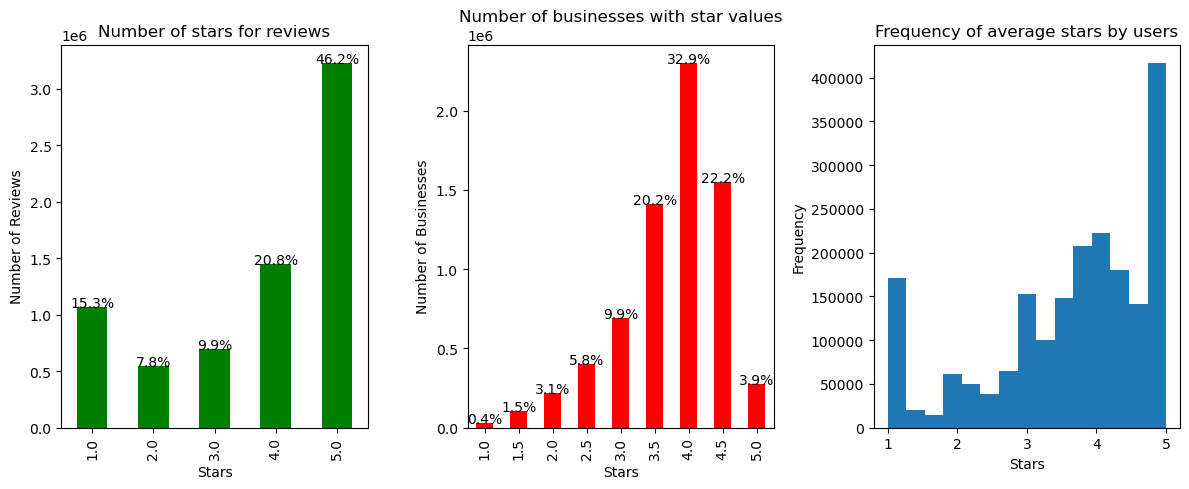

In [445]:
plt.figure(figsize = (12, 5))

# 1. Bar chart for ratings (number of stars) for reviews   
plt.subplot(1, 3, 1)
yelp.stars_review.value_counts().sort_index().plot.bar(color = 'green')

# Add percentage labels on top of the bars
values = yelp.stars_review.value_counts().sort_index()
total = yelp.stars_review.value_counts().sum()
percentages = [(value / total) * 100 for value in values]
for i, value in enumerate(values):
    plt.text(i, value + 1, f'{percentages[i]:.1f}%', ha='center')

# Add labels and title  
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')
plt.title('Number of stars for reviews')

# 2. Bar chart for average rating of business
plt.subplot(1,3,2)
yelp.stars_business.value_counts().sort_index().plot.bar(color = 'red')

# Add percentage labels on top of the bars
values = yelp.stars_review.value_counts().sort_index()
total = yelp.stars_review.value_counts().sum()
percentages = [(value / total) * 100 for value in values]
for i, value in enumerate(values_1):
    plt.text(i, value + 1, f'{percentages_1[i]:.1f}%', ha='center')
    
# Add labels and title 
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')
plt.title('Number of businesses with star values')

# 3. Histogram for average stars by each user 
plt.subplot(1,3,3)
user.average_stars.plot.hist(bins = 15)

# Add labels and title
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Frequency of average stars by users')


# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the subplots
plt.show()

- The first plot reveals that a significant portion, precisely 46.2%, of the reviews received the highest rating of 5 stars.
- In the second plot, it becomes evident that 33% of businesses recieved 4-star rating on Yelp.
- In the histogram, there is a prominent concentration of ratings observed within the range of 4 to 5 stars. 
<br>

**An overall observation indicates a higher frequency of star ratings falling within the range of 4 to 5 stars.**

## 3.2. During the time

To visualize trends spanning from 2005 to 2022, examine the data on a yearly basis.

In [460]:
# add a new column with only year value
yelp['year_review'] = yelp['date_format'].dt.year


# add a new column with only year value
yelp['year_yelping'] = yelp['date_format_yelping'].dt.year

### Review and new users during the years

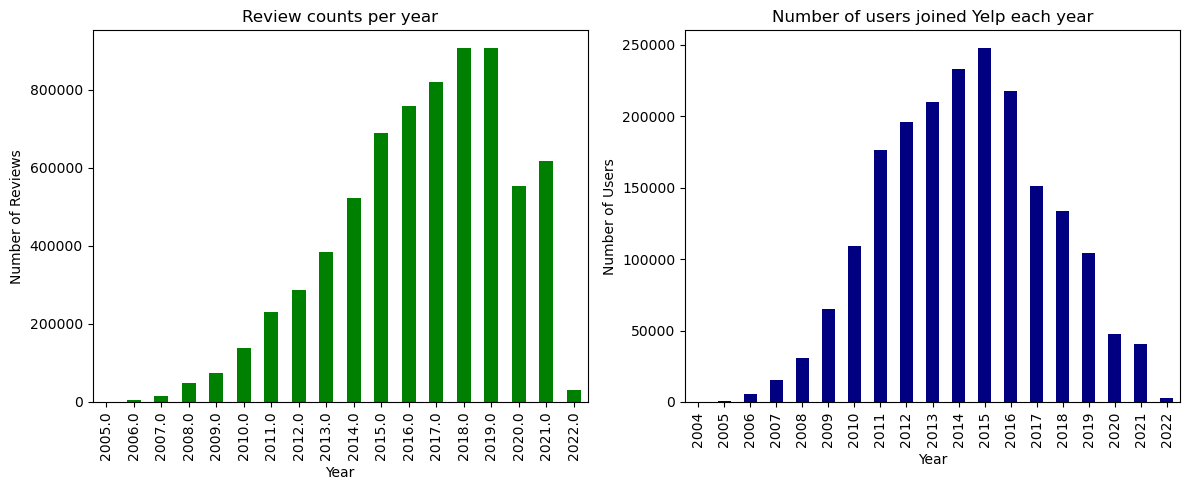

In [481]:
plt.figure(figsize=(12,5))

# plot a bar chart for presenting the number of reviews in each year
plt.subplot(1,2,1)
yelp['year_review'].value_counts().sort_index().plot.bar(color = 'green')

# Title and labels
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Review counts per year')


# Plot a bar chart to visualize the number of users who joined Yelp in each year 
plt.subplot(1,2,2)
user.year_yelping.value_counts().sort_index().plot.bar(color = 'navy')

# Title and labels
plt.title('Number of users joined Yelp each year')
plt.xlabel('Year')
plt.ylabel('Number of Users')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the subplots
plt.show()

- These bar charts indicate the trend of the number of reviews and new users on Yelp between 2005 to 2022.
- The first chart highlights a significant decrease in 2020, likely due to the COVID-19 pandemic.

### Distribution of Reviews by Month and Day of the Week

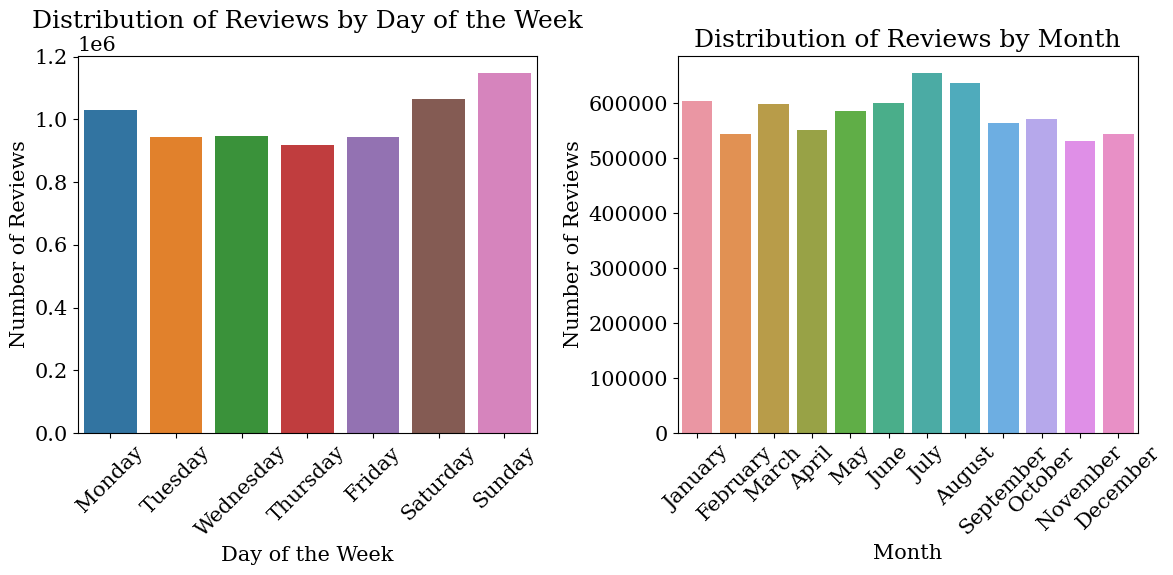

In [770]:
# Extract day of the week and month
yelp['day_of_week'] = yelp['date_format'].dt.day_name()
yelp['month'] = yelp['date_format'].dt.month_name()

# Set the order of days and months for proper plotting
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6))
# Plot for day of the week
plt.subplot(1,2,1)
sns.countplot(x='day_of_week', data=yelp, order=days_order)
plt.title('Distribution of Reviews by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)


# Plot for month
plt.subplot(1,2,2)
sns.countplot(x='month', data=yelp, order=months_order)
plt.title('Distribution of Reviews by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the subplots
plt.show()

These plots illustrate the distribution of reviews based on both months and days of the week, aiming to unveil any discernible patterns. However, with the existing dataset, it appears that there is no prominent trend in the number of reviews across days or months.

## 3.3. Explore the text column

In this section, we exemplify the counting of words in the text columns for the initial 5,000 reviews. We present the distribution of word counts per review as a means of assessing the textual volume in our dataset.

In [475]:
# Function to count words using nltk word_tokenize
def count_words_nlp(text):
    tokens = word_tokenize(text)
    return len(tokens)

# Apply the function
word_conut_5000 = yelp['text'][:5000].apply(count_words_nlp).sort_values(ascending= False)

# Create a dataframe with word counts 
df_word_5000 = pd.DataFrame(word_conut_5000)
df_word_5000.rename(columns={'text': 'word_count'}, inplace=True)

Some statstics:

In [476]:
df_word_5000.agg(['min', 'max', 'mean']).round(2)

,word_count
min,5.00
max,1018.00
mean,110.77


Plot a histgram to visualize the ditribution of word counts:

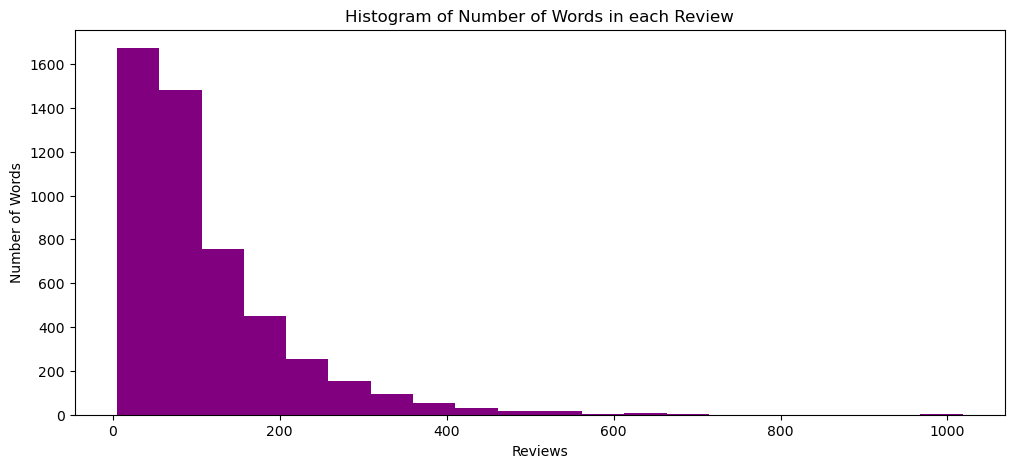

In [482]:
# Plot a histogram to show the distribution of number of words per review
plt.figure(figsize = (12,5))
plt.hist(df_word_5000['word_count'], bins = 20, color = 'purple')

# Titles and labels
plt.title('Histogram of Number of Words in each Review')
plt.xlabel('Reviews')
plt.ylabel('Number of Words')

#Showing the histogram
plt.show()

- The majority of reviews contain fewer than 400 words, indicating a trend towards concise feedback.
- Notably, there is a particularly extensive review with 1,129 words, which piques our curiosity. <br>
Let's explore that review!

In [298]:
# pd.set_option('display.max_colwidth', None)
print(review.text[df_word_1000['text'].index[0]])

Unfortunately, I'm NOT happy after coming to this salon yet again. I got a message from the owner saying he'd like to have me come in to receive a FREE service because they previously ruined my hair. So, I thought since he's the owner my hair would turn out good but I was wrong. I'm really unhappy with this whole experience. I showed him multiple photos on google of what I wanted done to my hair which was a lot of blonde. I told him I do not want any ORANGE in my hair as I wanted a "white blonde". He said you won't have any orange in your hair. I have a message from him the OWNER saying I would receive a FREE service if I deleted my previous review. He should of NEVER offered a free service if it wasn't really free! So, I said how much because I thought I was getting my hair done for free. He said since your hair is long and thick you'll have to pay for the hair color and "medicine" but he won't charge me for his time. I said ok how much he said $80. He said it would cost me $180 if he

## 3.4. Review count by users

<br>Considering the minimum and average review counts per user and businesses, it's evident that some users or businesses have significantly high review numbers. To better capture the distribution, we opt for the mean plus the standard deviation as a threshold for the maximum count. Subsequently, we'll visualize the distribution of review counts per user and businesses through two histograms.<br>

In [528]:
yelp.review_count_user.agg(['max', 'min', 'mean', 'std']).round(2)

max     17473.00
min         0.00
mean      123.83
std       363.43
Name: review_count_user, dtype: float64

In [529]:
yelp.review_count_business.agg(['max', 'min', 'mean', 'std']).round(2)

max     7568.00
min        5.00
mean     369.17
std      736.08
Name: review_count_business, dtype: float64

In [530]:
# Set a threshold for review_counts
user_reviews_less_150 = yelp.loc[yelp.review_count_user < (23.39+3*(82.57))]

# Set a threshold for review_counts for businesses
business_reviews_less_10 = yelp.loc[yelp.review_count_business < (370+3*(736))]

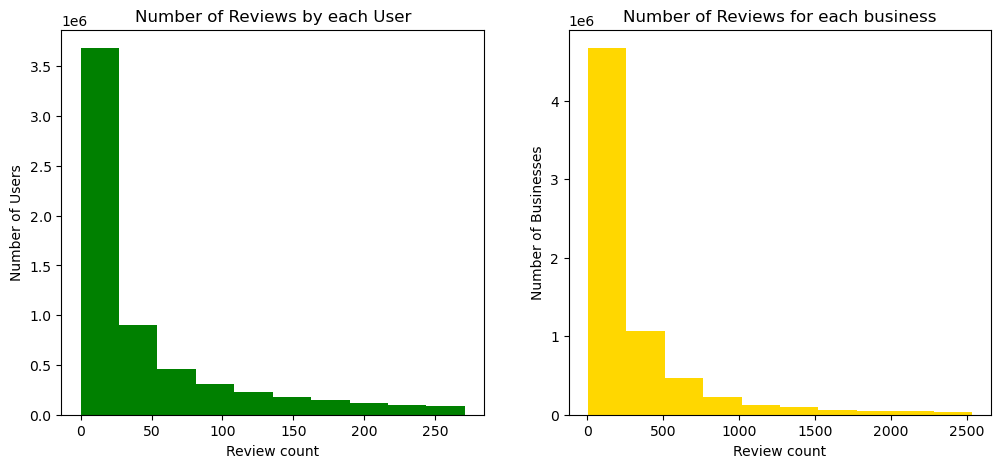

In [531]:
plt.figure(figsize = (12,5))
# Plot a histogram for review counts less than 150
plt.subplot(1,2,1)
user_reviews_less_150.review_count_user.plot.hist(bins = 10, color = 'green')

# Title and labels
plt.xlabel('Review count')
plt.ylabel('Number of Users')
plt.title('Number of Reviews by each User')

# Plot review counts for businesses
plt.subplot(1,2,2)
business_reviews_less_10.review_count_business.plot.hist(bins = 10, color = 'gold')

# Title and labels
plt.xlabel('Review count')
plt.ylabel('Number of Businesses')
plt.title('Number of Reviews for each business')


plt.show()

- This distributions provides a snapshot of the diversity in user engagement levels on the platform.
- The majority of users appear to have a relatively lower review count, with a gradual decrease in frequency as the review count increases. 


## 3.5. Geographical insights

Within this dataset, numerous variables related to the geographical location of each business, encompassing details such as address, state, city, latitude, and longitude. Let's delve into a closer examination of some of these location-based attributes.<br>
For a clearer representation, we trim our map data by excluding outliers with the lowest longitude values.

In [97]:
us_map['min_longitude'] = us_map.geometry.get_coordinates().reset_index().groupby('index').x.min()

In [98]:
us_map.sort_values('min_longitude').NAME.head()

27            Alaska
42            Hawaii
37    American Samoa
11        Washington
50            Oregon
Name: NAME, dtype: object

In [99]:
us_map.sort_values('min_longitude').NAME.tail()

41                                           Maine
13                                     Puerto Rico
38                    United States Virgin Islands
44                                            Guam
45    Commonwealth of the Northern Mariana Islands
Name: NAME, dtype: object

<br>**In this subplot featuring two distinct visualizations**:
<br>
- The first showcases a bar chart depicting the distribution of businesses across different states.
- The second offers a geographical perspective, presenting a map of the United States with marked business locations.

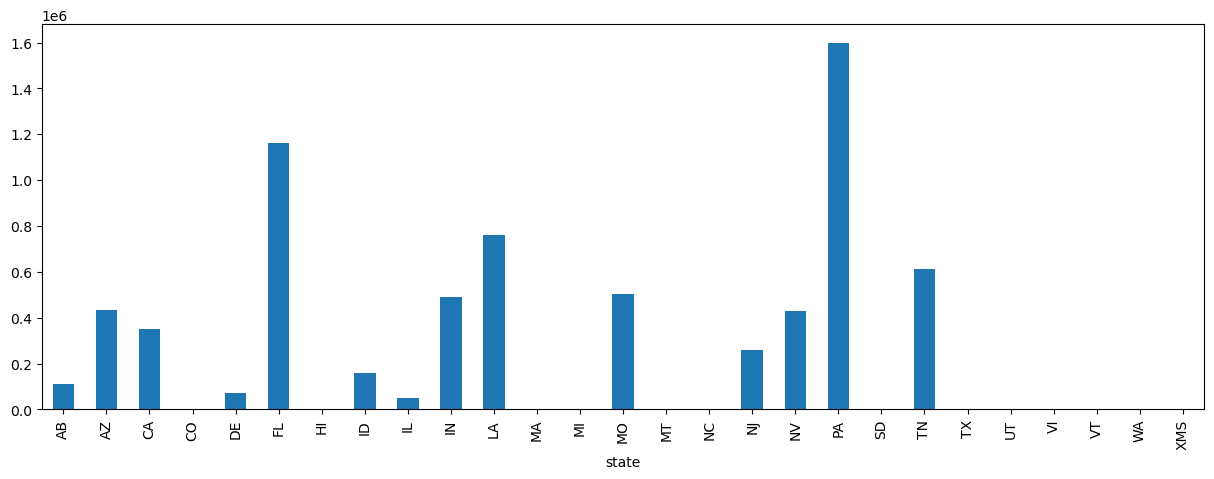

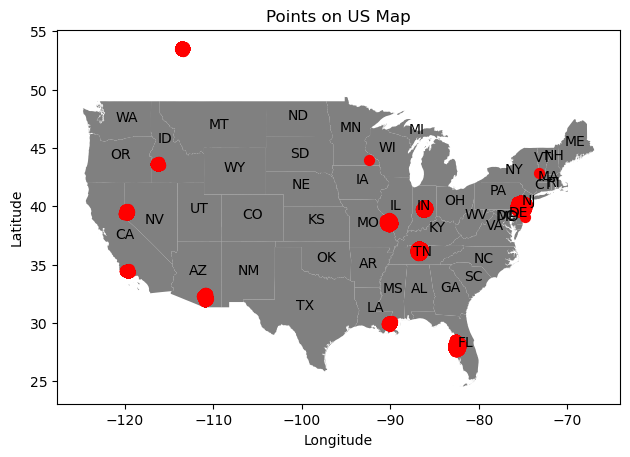

In [552]:
plt.figure(figsize=(15,5))


yelp.state.value_counts().sort_index().plot.bar()
plt.show()


# Create GeoDataFrame from latitude and longitude
geometry = [Point(lon, lat) for lon, lat in zip(business['longitude'], business['latitude'])]
gdf = gpd.GeoDataFrame(business, geometry=geometry, crs='EPSG:4326')

# Load the US shapefile
us_map = gpd.read_file('cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

# Plot the US map
fig, ax = plt.subplots()
us_map.loc[~us_map.NAME.isin(
    ['Alaska', 'Hawaii', 'American Samoa', 'Puerto Rico',
     'United States Virgin Islands', 'Guam',
     'Commonwealth of the Northern Mariana Islands']
)].plot(ax=ax, color='grey')
for idx, row in us_map.iterrows():
   plt.annotate(
       text=row.STUSPS,
       xy=row.geometry.representative_point().coords[:][0],
       ha='center',
       color='black',
   )

# Plot the points on the map
gdf.plot(ax=ax, color='red', marker='o', markersize=50)

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Points on US Map')


# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


- These two plots affirm that the Yelp dataset available here represents only a subset of their comprehensive dataset.
- The provided latitude and longitude values seem to be state-level approximations rather than precise coordinates.
- It's noteworthy that Pennsylvania appears to be the most represented state, while certain states, like Texas, lack data in this subset.

## 3.6. Attributes and Categories Analysis

In the Yelp dataset, the "categories" variable typically refers to the type or genre of a business. It encompasses a range of business classifications, such as "restaurants," "shopping," "nightlife," and more.
<br>

On the other hand, the "attributes" variable comprises a set of detailed characteristics or features associated with each business. These attributes can include specific amenities, service options, and other qualitative aspects of the business, often presented as a dictionary or key-value pairs. Examples include attributes like "OutdoorSeating," "GoodForKids," "WiFi," and more, reflecting diverse aspects of a business's offerings.

In [828]:
business.attributes[35]

'{\'OutdoorSeating\': \'True\', \'RestaurantsPriceRange2\': \'2\', \'BusinessAcceptsCreditCards\': \'True\', \'DogsAllowed\': \'True\', \'Ambience\': "{\'touristy\': False, \'hipster\': False, \'romantic\': False, \'divey\': False, \'intimate\': False, \'trendy\': False, \'upscale\': False, \'classy\': True, \'casual\': False}", \'HappyHour\': \'True\', \'GoodForMeal\': "{\'dessert\': False, \'latenight\': False, \'lunch\': False, \'dinner\': False, \'brunch\': False, \'breakfast\': False}", \'RestaurantsDelivery\': \'True\', \'HasTV\': \'True\', \'BusinessParking\': "{\'garage\': False, \'street\': False, \'validated\': False, \'lot\': True, \'valet\': False}", \'RestaurantsTakeOut\': \'True\', \'GoodForKids\': \'True\'}'

In [772]:
len(business.categories.value_counts())

83160

In [774]:
business.categories.value_counts().head(5)

categories
Beauty & Spas, Nail Salons    1012
Restaurants, Pizza             935
Nail Salons, Beauty & Spas     934
Pizza, Restaurants             823
Restaurants, Mexican           728
Name: count, dtype: int64

## 3.7. Correlation

In [200]:
correlation_matrix = yelp[['stars_review',
 'review_count_user',
 'average_stars',
 'stars_business',
 'review_count_business']].corr()

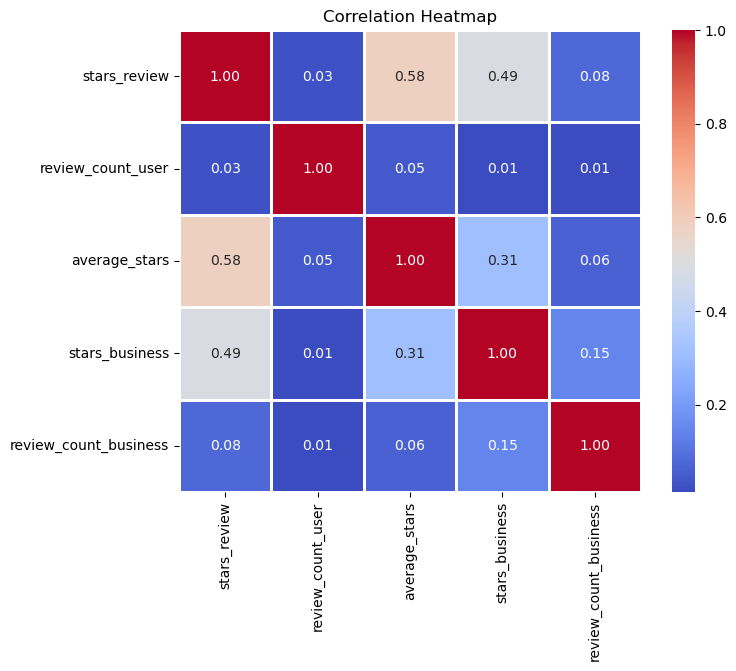

In [201]:
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, square=True)

# Adding title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

A correlation heatmap unveils connections, such as the correlation between user and average business ratings. However, it indicates that there isn't a highly significant relationship between numerical variables in this dataset.

# 4. Research Question

**Q: How can we assist business owners (particularly those with a Yelp profile) in identifying areas for improvement and gaining insights into their competitive landscape?** 

**Evaluate Weaknesses**:
Help business owners understand their weaknesses by analyzing user reviews on Yelp. This involves identifying recurring themes and concerns raised by customers to pinpoint specific areas that may benefit from improvement.

**Competitive Analysis**:
Provide a comprehensive analysis of competitors based on both location and business type. This includes highlighting competitors' strengths and positive aspects to offer a comparative view. By understanding the competitive landscape, business owners can strategize and differentiate themselves effectively.

**Attribute-Rating Relationship**:
Establish a clear understanding of the relationship between various business attributes and the stars counts. This involves exploring how specific aspects of the business influence customer reviews. Furthermore, we aim to develop predictive models to estimate the potential impact on star values when introducing new services or making changes to existing ones.

By addressing these aspects, my aim is to empower business owners with actionable insights, enabling them to enhance their operations, stand out in the market, and foster positive customer experiences on Yelp.

To conduct this evaluation, I plan to select a sample of the data and observe the results. The findings and insights generated from this analysis are applicable and transferable to various businesses and locations with ease.

In this step, we narrow down our focus by selecting a specific state and city for analysis. As an illustrative example, we choose **California** as the state of interest and **Santa Barbara** as the city for more in-depth exploration.

In [776]:
yelp_ca = yelp.loc[yelp.state == 'CA']

#create a new dataframe for using all the data of Santa Barbara city
santa_barbara = yelp_ca[yelp_ca.city.str.contains('santa' and 'barbara', case = False)]
santa_barbara.head(2)

,review_id,user_id,business_id,stars_review,text,date_format,name_business,address,city,state,...,is_open,attributes,categories,hours,name_user,review_count_user,date_format_yelping,average_stars,day_of_week,month
839,6tCTQCuSJP1_qemJ-3sRgQ,NMLvjdY7IOdtfU0TepvUuA,U3grYFIeu6RgAAQgdriHww,4.0,You can't get much closer to your meal unless ...,2013-11-06 18:47:15,Brophy Bros - Santa Barbara,119 Harbor Way,Santa Barbara,CA,...,1,"{'NoiseLevel': ""u'loud'"", 'RestaurantsReservat...","Cocktail Bars, Fish & Chips, Nightlife, Seafoo...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",Zach,483,2011-01-30 22:05:52,3.46,Wednesday,November
1937,3lkKJlBG8RpIHJ3sh60DZQ,-V_gxe3Av93zpL2bFoqaKw,b7UPlhqUiliUy9vITKHGvQ,2.0,The price we paid for our room was not in line...,2018-06-04 14:26:10,The Wayfarer,12 E Montecito St,Santa Barbara,CA,...,0,"{'RestaurantsPriceRange2': '2', 'WiFi': ""u'fre...","Venues & Event Spaces, Hotels & Travel, Event ...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",James,39,2012-06-03 15:31:32,3.62,Monday,June


## 4.1. Evaluate weaknesses of businesses

In this section, our aim is to leverage sentiment analysis to categorize comments into negative and positive sentiments for each business. To enhance the utility and informativeness of this process, we've implemented aspect term extraction and sentiment classification. This enables us to provide business owners with valuable insights derived from the reviews, offering a nuanced understanding of customer sentiments and identifying key aspects that contribute to the overall sentiment of the reviews.

#### Simple nltk application

In [18]:
nltk.download(['vader_lexicon'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zeinab/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [119]:
from nltk import sentiment
import operator

sia = sentiment.SentimentIntensityAnalyzer()
find_sentiment_score = lambda x: sia.polarity_scores(x)['compound']

In [148]:
import datetime as dt
#Using datetime for showing the start time of processing 
print(dt.datetime.now())

#Save sentiment scores
sentiment_scores = santa_barbara['text'].apply(find_sentiment_score)

#Using datetime for showing the finish time of processing 
print(dt.datetime.now())

2023-12-07 12:12:00.338663
2023-12-07 12:13:42.433774


In [149]:
santa_barbara['sentiment_scores'] = sentiment_scores

Now that we've completed sentiment analysis for all businesses in Santa Barbara on Yelp, let's proceed to the next phase, where we will specifically evaluate reviews for two selected businesses within the city. One of them is in businesses rated more than 4 stars and the other one is between businesses with rating less than 3 stars.
<br>
To optimize code execution time, given that processing 1000 reviews took approximately half an hour, we have strategically chosen businesses with fewer than 600 reviews for this analysis. This decision ensures a more efficient and manageable processing duration while still capturing meaningful insights from the selected businesses. 

**Business with rating more than 4 star**

In [333]:
# businesses in Santa Barbara with rating more than 4 stars and review count less than 600 
sb_600_4 = santa_barbara[(santa_barbara.review_count_business < 600) & (santa_barbara.stars_business > 4) ]

In [342]:
sb_600_4.business_id.value_counts().head()

business_id
54oLdsGU9B8HxFTqCCqV-A    606
hPzPpfSjgQkpWCD7YjcY-A    605
BErYojCJSO959vzaz9JclQ    586
r2IhvKZQ_wLR5mLBnPOilg    572
bp482wqF6v80AltDNlPDfw    547
Name: count, dtype: int64

In [777]:
print(santa_barbara.loc[santa_barbara.business_id == 'BErYojCJSO959vzaz9JclQ']['name_business'].value_counts())
print(santa_barbara.loc[santa_barbara.business_id == 'BErYojCJSO959vzaz9JclQ']['categories'].unique())
print(santa_barbara.loc[santa_barbara.business_id == 'BErYojCJSO959vzaz9JclQ']['stars_business'].unique())

name_business
Savoy Cafe & Deli    586
Name: count, dtype: int64
['Restaurants, Delis, Coffee & Tea, Breakfast & Brunch, Food, Gluten-Free, Cafes, Beer, Wine & Spirits']
[4.5]


<br>**Business with rating less than 3 star**

In [ ]:
# businesses in Santa Barbara with rating less than 3 stars and review count less than 600 
sb_600_3 = santa_barbara[(santa_barbara.review_count_business < 600) & (santa_barbara.stars_business < 3) ]

In [ ]:
sb_600_3.business_id.value_counts().head()

business_id
TCWnTa69sJ3vGQsdEe3Esw    331
MWKowhzHQ_scqnJEqAUYgA    290
HrnSaz2f1WUEoAQQ6iD6gw    272
yw3vRR7XLIjEnlhMnVzR7w    244
KzzGpjfUs3DGkNGi46yoeA    240
Name: count, dtype: int64

In [778]:
print(santa_barbara.loc[santa_barbara.business_id == 'TCWnTa69sJ3vGQsdEe3Esw']['name_business'].value_counts())
print(santa_barbara.loc[santa_barbara.business_id == 'TCWnTa69sJ3vGQsdEe3Esw']['categories'].unique())
print(santa_barbara.loc[santa_barbara.business_id == 'TCWnTa69sJ3vGQsdEe3Esw']['stars_business'].unique())

name_business
Uncle Roccos Famous NY Pizza    331
Name: count, dtype: int64
['Pizza, Italian, Fast Food, Restaurants']
[2.5]


They are two restaurants: 
1. Savoy Cafe & Deli, restaurant with 4.5 stars and 586 review counts
2. Uncle Roccos Famous NY Pizza, fastfood restaurant with 2.5 stars and 331 reviews

<br>

### Savoy Cafe & Deli

First we create a dataframe for this restaurant:

In [164]:
Savoy = santa_barbara.loc[santa_barbara['business_id'] == 'BErYojCJSO959vzaz9JclQ']
Savoy.text

51287      Great little breakfast or lunch spot where you...
51355      Love this place! Their salads at the counter a...
52443      Order the iced mocha! It has shaved chocolate ...
54348      One of my favorites in all of Santa Barbara.  ...
55334      First heard about savoy for their amazing sala...
                                 ...                        
6905103    This place has DELICIOUS food!\n\nI ordered th...
6905104    Great food and service! I don't live in the ar...
6905105    The food was good, a bit pricey but delicious....
6905106    I tried Savoy because my friend Julie highly r...
6905107    There are several of our favorites on Figueroa...
Name: text, Length: 586, dtype: object

<br><br>
The initial sentiment analysis methods did not fully address the specificity required for my research question. In search of a more tailored approach to highlight specific aspects mentioned in reviews, I explored various NLP packages and libraries. Ultimately, the aspect extractor model proved to be the most suitable choice for extracting nuanced insights from the reviews by identifying and categorizing key aspects and associated sentiments.

- The aspect extractor model is designed to identify and extract specific aspects or features mentioned in textual data, particularly customer reviews. 
- It employs natural language processing techniques to recognize **key aspects** related to a given domain, such as aspects of a product or service in the context of reviews. 
- The model may also predict **sentiments** associated with each identified aspect, categorizing them as positive, negative, or neutral.

Term extraction and sentiment classification:
- Extract aspect terms and sentiments from the text reviews of a business named "Savoy" using a pre-trained aspect extraction model.
- Create a DataFrame (aspect_sentiment_Savoy) to organize and display the extracted aspects and sentiments, converting the results into a tabular format for easier analysis and interpretation.

In [225]:
warnings.filterwarnings("ignore")

In [167]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(
    checkpoint='english',
     auto_device=True  # False means load model on CPU
)

[2023-12-07 12:53:45] (2.3.4) Downloading checkpoint:english 
[2023-12-07 12:53:45] (2.3.4) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2023-12-07 12:53:45] (2.3.4) Checkpoint already downloaded, skip
[2023-12-07 12:53:45] (2.3.4) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2023-12-07 12:53:45] (2.3.4) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2023-12-07 12:53:45] (2.3.4) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2023-12-07 12:53:45] (2.3.4) model: None
[2023-12-07 12:53:45] (2.3.4) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2023-12-07 12:53:45] (2.3.4)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [168]:
import datetime as dt

print(dt.datetime.now())
aspect_result = aspect_extractor.extract_aspect(
    inference_source=list(Savoy.text),
    pred_sentiment=True,
    save_result=False,
    print_result=False,
)
print(dt.datetime.now())

2023-12-07 12:54:18.235693


classifying aspect sentiments: 100%|██████████| 60/60 [03:54<00:00,  3.92s/it]

2023-12-07 12:59:28.117816


In [209]:
aspect_sentiment_Savoy = pd.DataFrame(
    [
        dict(zip(
            [a.lower() for a in result['aspect']],
            [s.lower() for s in result['sentiment']]
        ))
        for result in aspect_result
    ]
)
aspect_sentiment_Savoy

,breakfast,lunch spot,coffee,food,location,salads,teas,prices,atmosphere,service,...,chili flavor,turkey posole,broccoli,kombucha,gal assisting,payed,red rice salad,person,handlebar roasters coffee,sub sandwich
0,neutral,neutral,positive,positive,positive,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,positive,NaN,positive,positive,negative,positive,positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,positive,NaN,NaN,NaN,NaN,negative,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN
582,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583,NaN,NaN,negative,positive,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN
584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN


In [276]:
pd.unique(aspect_sentiment_Savoy.values.reshape(-1))

array(['neutral', 'positive', '', 'negative'], dtype=object)

In [277]:
# Save it as new df
as_Savoy = aspect_sentiment_Savoy

In [279]:
# Clean the data
columns_to_drop = ['people', 'it', 'everything', 'girl','folks', 'guys', 'guy','take','everyone','they', 'go']
as_Savoy = as_Savoy.drop(columns=columns_to_drop)

In [414]:
# Finding the most frequent aspects in positive revews
(as_Savoy == 'negative').sum().sort_values(ascending=False).head(10)

food         15
service       8
staff         7
bread         6
coffee        6
employees     4
chairs        3
salad         3
wait          3
order         3
dtype: int64

In [415]:
# Finding the most frequent aspects in negative revews
(as_Savoy == 'positive').sum().sort_values(ascending=False).head(10)

food          188
staff          79
service        67
salad bar      60
atmosphere     54
place          42
options        40
coffee         32
breakfast      26
ambiance       20
dtype: int64

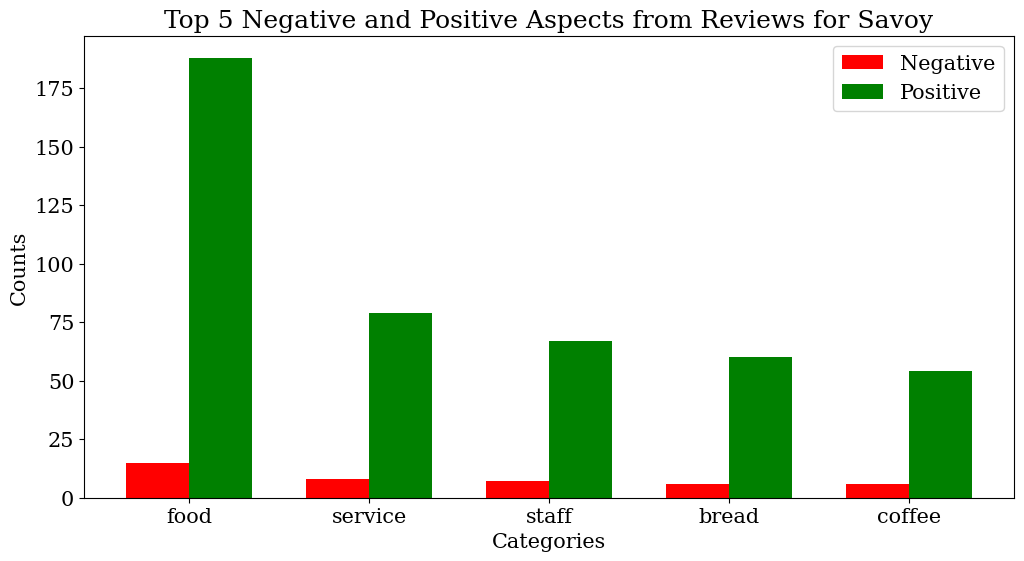

In [781]:
negative_counts = (as_Savoy == 'negative').sum().sort_values(ascending=False).head(5)
positive_counts = (as_Savoy == 'positive').sum().sort_values(ascending=False).head(5)

# Plotting a grouped bar chart
plt.figure(figsize=(12, 6))

bar_width = 0.35
index = range(len(negative_counts))

plt.bar(index, negative_counts, width=bar_width, color='red', label='Negative')
plt.bar([i + bar_width for i in index], positive_counts, width=bar_width, color='green', label='Positive')

plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Top 5 Negative and Positive Aspects from Reviews for Savoy')
plt.xticks([i + bar_width/2 for i in index], negative_counts.index)
plt.legend()

# Display the chart
plt.show()


The bar chart highlights substantial differences in the number of mentions between positive and negative reviews. The analysis suggests that aspects related to food quality, service, and staff receive significant praise from reviewers, contributing to a positive sentiment overall.

### Uncle Roccos Famous NY Pizza

First we create a dataframe for this restaurant:

In [361]:
Roccos = santa_barbara.loc[santa_barbara['business_id'] == 'TCWnTa69sJ3vGQsdEe3Esw']

Term extraction and sentiment classification:

In [167]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(
    checkpoint='english',
     auto_device=True  # False means load model on CPU
)

[2023-12-07 12:53:45] (2.3.4) Downloading checkpoint:english 
[2023-12-07 12:53:45] (2.3.4) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2023-12-07 12:53:45] (2.3.4) Checkpoint already downloaded, skip
[2023-12-07 12:53:45] (2.3.4) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2023-12-07 12:53:45] (2.3.4) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2023-12-07 12:53:45] (2.3.4) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2023-12-07 12:53:45] (2.3.4) model: None
[2023-12-07 12:53:45] (2.3.4) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2023-12-07 12:53:45] (2.3.4)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [346]:
print(dt.datetime.now())
aspect_result_Roccos = aspect_extractor.extract_aspect(
    inference_source=list(Roccos.text),
    pred_sentiment=True,
    save_result=False,
    print_result=False,
)
print(dt.datetime.now())

2023-12-07 17:10:45.229218


classifying aspect sentiments: 100%|██████████| 31/31 [02:06<00:00,  4.08s/it]

2023-12-07 17:13:34.735716


In [383]:
as_Roccos = pd.DataFrame(
    [
        dict(zip(
            [a.lower() for a in result['aspect']],
            [s.lower() for s in result['sentiment']]
        ))
        for result in aspect_result_Roccos
    ]
)
as_Roccos

,counter,line,paid,minutes,pizza,water,service,crust,pepperoni,atmosphere,...,decor,wait time,premises,drink,restroom,house salad,serve,olive,bathroom,door
0,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,negative,negative,negative,negative,positive,neutral,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative,neutral,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,NaN,positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,NaN,NaN,NaN,NaN,NaN,NaN,negative,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,NaN,NaN,NaN,NaN,NaN,NaN,negative,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,NaN,negative,NaN,NaN,positive,NaN,negative,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [384]:
pd.unique(as_Roccos.values.reshape(-1))

array(['negative', nan, 'positive', 'neutral'], dtype=object)

In [385]:
#Clean the data
columns_to_drop = ['much', 'it', 'lady', 'guy','one guy', 'door', 'him','get','he','people', 'guys']
as_Roccos = as_Roccos.drop(columns=columns_to_drop)

In [387]:
# Finding the most frequent aspects in positive revews
(as_Roccos == 'positive').sum().sort_values(ascending=False).head(5)

pizza         114
service        23
crust          23
place          15
atmosphere     14
dtype: int64

In [408]:
#solve the overlap
neg_rac['price_agg'] = neg_rac['prices']+neg_rac['price']

In [407]:
# Finding the most frequent aspects in negative revews
neg_rac = (as_Roccos == 'negative').sum().sort_values(ascending=False).head(6)
neg_rac

pizza      74
service    45
food       17
prices     14
price      11
place      10
dtype: int64

In [412]:
#Solving the overlap
neg_rac = neg_rac.drop(index = ['prices', 'price'])
neg_rac

pizza        74
service      45
food         17
place        10
price_agg    25
dtype: int64

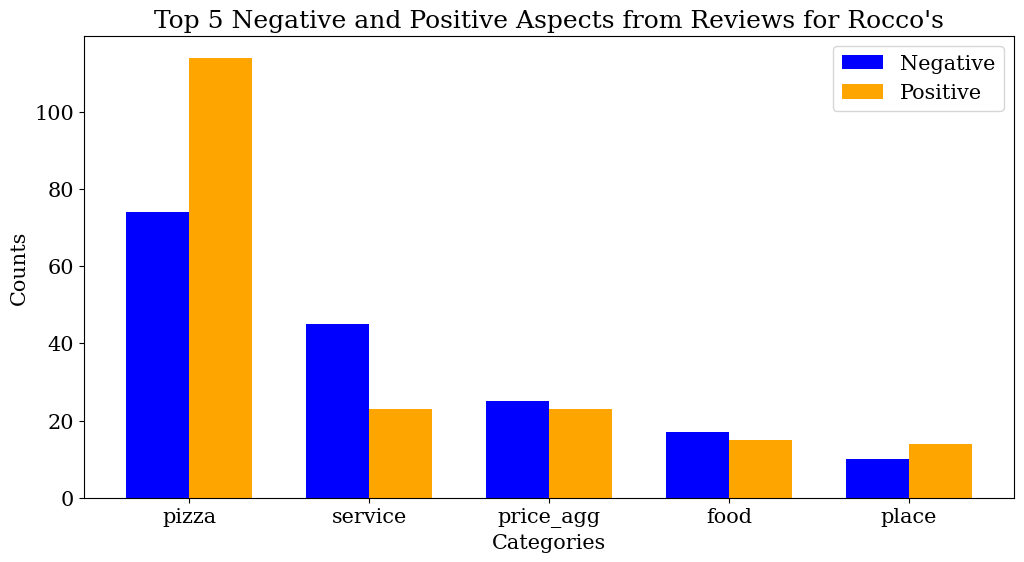

In [782]:
negative_counts_roccos = neg_rac.sort_values(ascending=False)
positive_counts_roccos = (as_Roccos == 'positive').sum().sort_values(ascending=False).head(5)

# Plotting a grouped bar chart
plt.figure(figsize=(12, 6))

bar_width = 0.35
index_roccos = range(len(negative_counts_roccos))

plt.bar(index_roccos, negative_counts_roccos, width=bar_width, color='blue', label='Negative')
plt.bar([i + bar_width for i in index_roccos], positive_counts_roccos, width=bar_width, color='orange', label='Positive')

plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Top 5 Negative and Positive Aspects from Reviews for Rocco\'s')
plt.xticks([i + bar_width/2 for i in index_roccos], negative_counts_roccos.index)
plt.legend()

# Display the chart
plt.show()


<br>This bar chart illustrates the balance between positive and negative aspects for Rocco's business. Despite a notable number of dissatisfied comments regarding its pizza, a larger proportion of users express appreciation for the pizza quality. Several speculations arise from the observed low rating:

1. A larger dataset with more reviews is needed for a comprehensive understanding.
2. Users might prefer rating with stars over providing written reviews.
3. Focusing on addressing negative reviews could be crucial.
4. Exploring alternative analyses may yield better insights.

To delve deeper into this matter, I selected another business with low rating but a higher number of review counts.

In [488]:
# businesses in Santa Barbara with rating less than 3 stars and review count less than 800 
sb_800_3 = santa_barbara[(santa_barbara.review_count_business < 800) & (santa_barbara.stars_business < 3) ]

In [489]:
sb_800_3.business_id.value_counts().head()

business_id
v1Uesklh8DpEufYOhTq4iA    784
TCWnTa69sJ3vGQsdEe3Esw    331
MWKowhzHQ_scqnJEqAUYgA    290
HrnSaz2f1WUEoAQQ6iD6gw    272
yw3vRR7XLIjEnlhMnVzR7w    244
Name: count, dtype: int64

In [419]:
print(santa_barbara.loc[santa_barbara.business_id == 'v1Uesklh8DpEufYOhTq4iA']['name_business'].value_counts())
print(santa_barbara.loc[santa_barbara.business_id == 'v1Uesklh8DpEufYOhTq4iA']['categories'].unique())
print(santa_barbara.loc[santa_barbara.business_id == 'v1Uesklh8DpEufYOhTq4iA'].stars_business.unique())

name_business
Mar Monte Hotel - Hyatt    784
Name: count, dtype: int64
['Hotels, Restaurants, Beauty & Spas, Hotels & Travel, Day Spas, Event Planning & Services']
[2.5]


### Mar Monte Hotel

First we create a dataframe for this restaurant:

In [420]:
Monte = santa_barbara.loc[santa_barbara['business_id'] == 'v1Uesklh8DpEufYOhTq4iA']

Term extraction and sentiment classification:

In [167]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(
    checkpoint='english',
     auto_device=True  # False means load model on CPU
)

[2023-12-07 12:53:45] (2.3.4) Downloading checkpoint:english 
[2023-12-07 12:53:45] (2.3.4) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2023-12-07 12:53:45] (2.3.4) Checkpoint already downloaded, skip
[2023-12-07 12:53:45] (2.3.4) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2023-12-07 12:53:45] (2.3.4) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2023-12-07 12:53:45] (2.3.4) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2023-12-07 12:53:45] (2.3.4) model: None
[2023-12-07 12:53:45] (2.3.4) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2023-12-07 12:53:45] (2.3.4)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [421]:
print(dt.datetime.now())
aspect_result_Monte = aspect_extractor.extract_aspect(
    inference_source=list(Monte.text),
    pred_sentiment=True,
    save_result=False,
    print_result=False,
)
print(dt.datetime.now())

2023-12-07 17:49:46.005557


classifying aspect sentiments: 100%|██████████| 71/71 [04:51<00:00,  4.11s/it]

2023-12-07 17:56:20.993883


In [442]:
as_Monte = pd.DataFrame(
    [
        dict(zip(
            [a.lower() for a in result['aspect']],
            [s.lower() for s in result['sentiment']]
        ))
        for result in aspect_result_Monte
    ]
)
as_Monte.head(5)

,location,room,view,staff,management,carpets,bed,bath towels,sandwich,$,...,soap,reception clerk,machine,housekeeper,ice machine,spent,patio,pictures,line,ocean - view rooms
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,positive,positive,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,positive,negative,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,negative,positive,negative,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [428]:
pd.unique(as_Monte.values.reshape(-1))

array([nan, 'positive', 'negative', 'neutral'], dtype=object)

In [431]:
(as_Monte == 'negative').sum().sort_values(ascending=False).head(7)

room       129
rooms       79
service     64
staff       41
price       39
$           29
place       25
dtype: int64

In [792]:
# solve the overlap
neg_mon = (as_Monte == 'negative').sum().sort_values(ascending=False).head(7)

In [793]:
neg_mon['room_quality'] = neg_mon['room']+neg_mon['rooms']
neg_mon['price_agg'] = neg_mon['price']+neg_mon['$']

In [794]:
neg_mon = neg_mon.drop(index=['room', 'rooms', 'price', '$'])

In [795]:
neg_mon

service          64
staff            41
place            25
room_quality    208
price_agg        68
dtype: int64

In [785]:
(as_Monte == 'positive').sum().sort_values(ascending=False).head(6)

staff       137
room         81
service      70
location     69
rooms        40
pool         34
dtype: int64

In [786]:
# solve the overlap
pos_mon = (as_Monte == 'positive').sum().sort_values(ascending=False).head(6)

In [787]:
pos_mon['room_quality'] =pos_mon['room']+pos_mon['rooms']

In [788]:
pos_mon = pos_mon.drop(index=['room', 'rooms'])

In [789]:
pos_mon.sort_values(ascending=False)

staff           137
room_quality    121
service          70
location         69
pool             34
dtype: int64

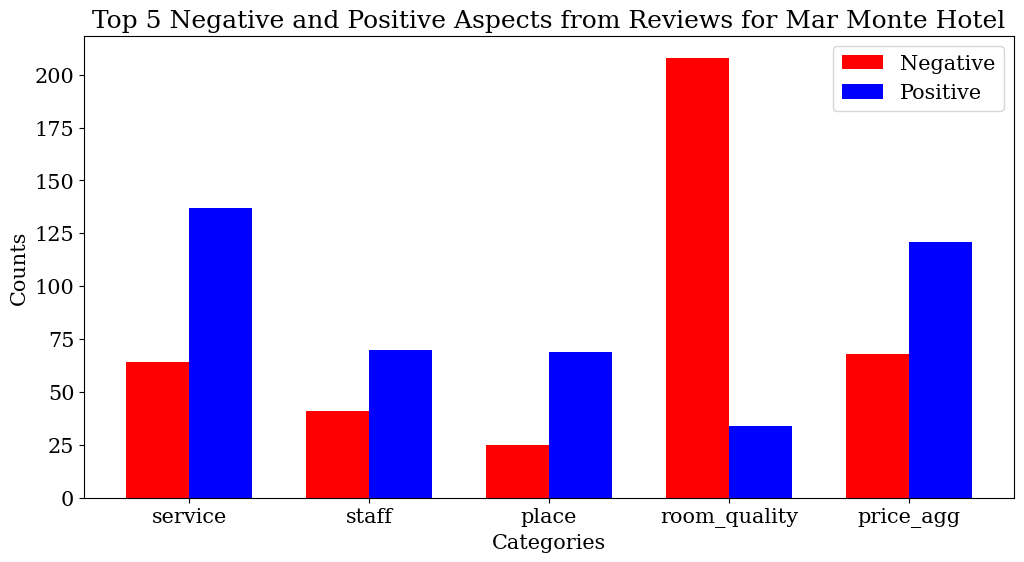

In [796]:
negative_counts_monte = neg_mon
positive_counts_monte = pos_mon

# Plotting a grouped bar chart
plt.figure(figsize=(12, 6))

bar_width = 0.35
index_monte = range(len(negative_counts_monte))

plt.bar(index_monte, negative_counts_monte, width=bar_width, color='red', label='Negative')
plt.bar([i + bar_width for i in index_monte], positive_counts_monte, width=bar_width, color='blue', label='Positive')

plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Top 5 Negative and Positive Aspects from Reviews for Mar Monte Hotel' )
plt.xticks([i + bar_width/2 for i in index_monte], negative_counts_monte.index)
plt.legend()

# Display the chart
plt.show()


The negative aspects exhibit substantial disparities from the positives, especially concerning the "quality of room." However, other aspects do not display significant differences. Considering the impact of the number of reviews may provide a better insight.

## 4.2. Competitive Analysis

Provide a comprehensive analysis of competitors based on both location and business type. This includes highlighting competitors' strengths and positive aspects to offer a comparative view. By understanding the competitive landscape, business owners can strategize and differentiate themselves effectively.

In this section, our focus is on a specific business previously identified with a rating below 3 stars – The Uncle Roccos Famous NY Pizza. Our objective is to identify competitors within the same city, analyze their strengths, and provide valuable insights to the business owner of the low-rated restaurant. Let's start by exploring the business category of The Uncle Roccos Famous NY Pizza.

In [565]:
print(santa_barbara.loc[santa_barbara.business_id == 'TCWnTa69sJ3vGQsdEe3Esw']['name_business'].value_counts())
print(santa_barbara.loc[santa_barbara.business_id == 'TCWnTa69sJ3vGQsdEe3Esw']['categories'].unique())

name_business
Uncle Roccos Famous NY Pizza    331
Name: count, dtype: int64
['Pizza, Italian, Fast Food, Restaurants']


In order to conduct a comprehensive competitive analysis for Roccos, a fast-food restaurant in Santa Barbara, we follow these strategic steps:

1. **Identify Successful Competitors**:
- Separate fast-food restaurants in Santa Barbara with a high success rate, characterized by a rating exceeding 4 stars.
2. **Evaluate User Engagement and Ratings**:

- Calculate the average review_counts to gauge user engagement.
- Determine the average stars (ratings) to assess overall customer satisfaction.
3. **Attribute Comparison**:

- Compare the attributes of these successful competitors with Roccos' active attributes.
- Gain insights into common features contributing to their success.
4. **Topic Sentiment Analysis**:

- Apply advanced sentiment analysis on text reviews of these competitors.
- Uncover points of strength mentioned in positive comments to understand what resonates well with customers.

<br>By systematically analyzing these factors, we aim to provide valuable insights to Roccos, enabling them to enhance their competitive edge in the fast-food market of Santa Barbara.

### 1. Identify Successful Competitors

In [560]:
santa_barbara = santa_barbara.dropna(subset=['categories'])

In [582]:
santa_barbara_fastfoods = santa_barbara[santa_barbara.categories.str.contains('restaurants' and 'fast food', case = False)]

In [583]:
santa_barbara_fastfoods = santa_barbara_fastfoods[santa_barbara_fastfoods.stars_business >= 4]

In [682]:
len(santa_barbara_fastfoods)

3961

Rocco has **3961** competitors in food industry. 

### 2. Evaluate User Engagement and Ratings

In [690]:
print('Rocco has', len(santa_barbara.loc[santa_barbara.business_id == 'TCWnTa69sJ3vGQsdEe3Esw']), 'reviews on Yelp', 'and the average', 
      'of review count for similar businesses in Santa Barbara is', santa_barbara_fastfoods.review_count_business.mean().round(2))

Rocco has 331 reviews on Yelp and the average of review count for similar businesses in Santa Barbara is 740.05


In [691]:
print('Rocco has', santa_barbara.loc[santa_barbara.business_id == 'TCWnTa69sJ3vGQsdEe3Esw'].stars_business.unique(), 'average rating on Yelp',
      'and the average of stars for similar businesses in Santa Barbara is', santa_barbara_fastfoods.stars_business.mean().round(2))

Rocco has [2.5] average rating on Yelp and the average of stars for similar businesses in Santa Barbara is 4.3


### 3. Attribute Comparison

In Yelp's dataset, business attributes represent various characteristics and features associated with each business. These attributes provide detailed information about the establishment's amenities, services, and operational aspects. <br>Here we can see the Rocco's attributes:

In [678]:
import ast

# Your input string
input_str = santa_barbara.loc[santa_barbara.business_id == 'TCWnTa69sJ3vGQsdEe3Esw']['attributes'][51272]

# Convert the string to a dictionary
attributes_dict = ast.literal_eval(input_str)

# Identify keys with values set to "True"
true_attributes_rocco = [key for key, value in attributes_dict.items() if value == 'True']
true_attributes_rocco_df = pd.DataFrame(index = true_attributes_rocco)
true_attributes_rocco_df['Count_Rocco'] = 1

new_indices = ['OutdoorSeating', 'WheelchairAccessible', 'RestaurantsTableService', 
               'DogsAllowed', 'HappyHour', 'RestaurantsReservations', 
               'Corkage', 'DriveThru', 'BusinessAcceptsBitcoin']

# Create a DataFrame for new rows
new_rows = pd.DataFrame({'Count_Rocco': 0}, index=new_indices)

true_attributes_rocco_df = pd.concat([true_attributes_rocco_df, new_rows])

Find the available attributes of the successful fast food businesses in Sanata Barbara and make a data frame with the number of them. 

In [799]:
# Define a function to process each row
def extract_true_attributes(row):
    # Convert the string to a dictionary
    attributes_dict = ast.literal_eval(row['attributes'])
    
    # Identify keys with values set to "True"
    true_attributes = [key for key, value in attributes_dict.items() if value == 'True']
    
    return true_attributes

# Apply the function to each row and store the result in a new column
santa_barbara_fastfoods['True_Attributes'] = santa_barbara_fastfoods.apply(extract_true_attributes, axis=1)

In [800]:
from collections import Counter


# Concatenate all lists in the 'True_Attributes' column
all_attributes = [item for sublist in santa_barbara_fastfoods['True_Attributes'] for item in sublist]

# Count occurrences of each attribute
attribute_counts = Counter(all_attributes)

# Convert the Counter to a DataFrame for better presentation
attribute_counts_df = pd.DataFrame.from_dict(attribute_counts, orient='index', columns=['Count'])

# Sort the DataFrame by counts in descending order
attribute_counts_df = attribute_counts_df.sort_values(by='Count', ascending=False)

attribute_counts_df['Percentage'] = ((attribute_counts_df.Count / len(santa_barbara_fastfoods)) * 100 ).round(2)

To conduct a comprehensive comparison between Rocco and similar businesses, we merge the relevant information from two tables. The merging process allows for a side-by-side analysis of key attributes, user engagement metrics, and other pertinent details.

In [802]:
merged_df = pd.merge(attribute_counts_df, true_attributes_rocco_df, left_index=True, right_index=True)
merged_df

,Count,Percentage,Count_Rocco
RestaurantsGoodForGroups,3961,100.00,1
BusinessAcceptsCreditCards,3961,100.00,1
GoodForKids,3774,95.28,1
BikeParking,3694,93.26,1
OutdoorSeating,3533,89.19,0
RestaurantsTakeOut,3094,78.11,1
WheelchairAccessible,2610,65.89,0
RestaurantsDelivery,2591,65.41,1
Caters,2586,65.29,1
RestaurantsTableService,1749,44.16,0


The dataframe provides insights into the percentage of businesses with each attribute, showcasing attribute availability in Rocco's restaurant. For instance, while 90% of competitors offer outdoor seating, Rocco's does not provide this feature.

### 4. Topic Sentiment Analysis

Leverage the previously employed model to conduct topic sentiment analysis on successful businesses in Santa Barbara

In [584]:
print(dt.datetime.now())
aspect_result_ff = aspect_extractor.extract_aspect(
    inference_source=list(santa_barbara_fastfoods.text),
    pred_sentiment=True,
    save_result=False,
    print_result=False,
)
print(dt.datetime.now())

2023-12-07 21:52:29.635480


classifying aspect sentiments: 100%|██████████| 376/376 [26:47<00:00,  4.27s/it]


2023-12-07 22:27:30.565726


In [585]:
as_fastfoods = pd.DataFrame(
    [
        dict(zip(
            [a.lower() for a in result['aspect']],
            [s.lower() for s in result['sentiment']]
        ))
        for result in aspect_result_ff
    ]
)
as_fastfoods.head(5)

,serve,pastrami sandwich,pastrami,they,sandwich,smoothie,carob,smoothies,specials,shop,...,spicy chop salad,brioche bread,waiting time,extra pickle spears,max,vegan mayo,+ pesto,malta,take,female
0,negative,negative,negative,negative,negative,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,positive,positive,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive,positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [586]:
pd.unique(as_fastfoods.values.reshape(-1))

array(['negative', nan, 'positive', 'neutral'], dtype=object)

In [590]:
(as_fastfoods == 'positive').sum().sort_values(ascending=False).head(10)

service        744
food           681
tacos          432
staff          416
pizza          303
sandwiches     254
place          164
sandwich       163
ingredients    154
price          127
dtype: int64

In [610]:
# solve the overlap
pos_ff = (as_fastfoods == 'positive').sum().sort_values(ascending=False).head(10)

In [611]:
pos_ff['sandwich_g'] =pos_ff['sandwiches']+pos_ff['sandwich']

In [612]:
pos_ff = pos_ff.drop(index=['sandwiches', 'sandwich'])

In [613]:
pos_ff.index.values[8] = 'sandwich'

In [622]:
pos_ff = pos_ff.sort_values(ascending=False).head(6)

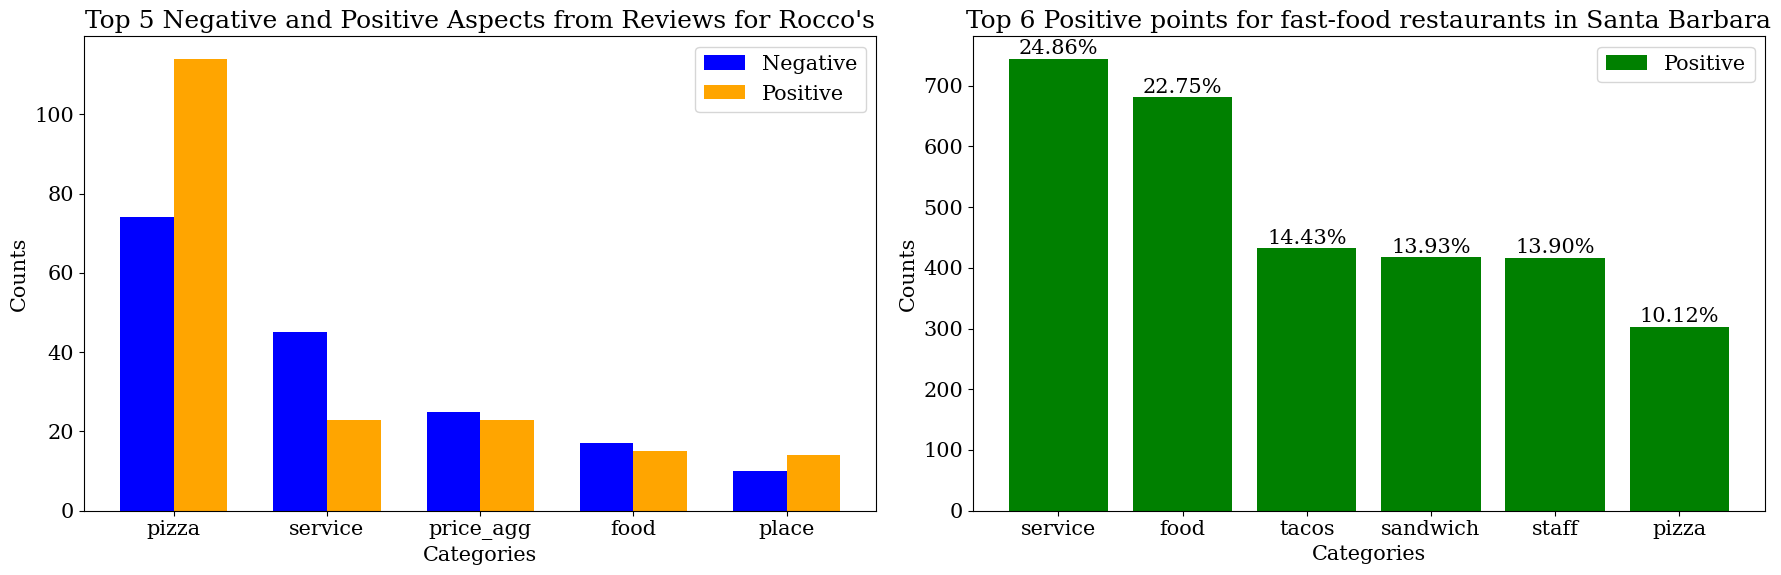

In [803]:
# Data for Rocco's
negative_counts_roccos = neg_rac.sort_values(ascending=False)
positive_counts_roccos = (as_Roccos == 'positive').sum().sort_values(ascending=False).head(5)

# Data for Santa Barbara fast foods'
positive_counts_monte = pos_ff

# Plotting subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot for Rocco's
bar_width = 0.35
index_roccos = np.arange(len(negative_counts_roccos))

axes[0].bar(index_roccos, negative_counts_roccos, width=bar_width, color='blue', label='Negative')
axes[0].bar(index_roccos + bar_width, positive_counts_roccos, width=bar_width, color='orange', label='Positive')

axes[0].set_xlabel('Categories')
axes[0].set_ylabel('Counts')
axes[0].set_title('Top 5 Negative and Positive Aspects from Reviews for Rocco\'s')

axes[0].set_xticks(index_roccos + bar_width/2)
axes[0].set_xticklabels(negative_counts_roccos.index)
axes[0].legend()

# Plot for Santa Barbara fast foods'
index_monte = np.arange(len(positive_counts_monte))

# Calculate percentages
total_counts = positive_counts_monte.sum()
percentages = (positive_counts_monte / total_counts) * 100

axes[1].bar(index_monte, positive_counts_monte, color='green', label='Positive')
# Display percentages on the bars
for i, value in enumerate(positive_counts_monte):
    axes[1].text(i, value + 1, f'{percentages.iloc[i]:.2f}%', ha='center', va='bottom')

axes[1].set_xlabel('Categories')
axes[1].set_ylabel('Counts')
axes[1].set_title('Top 6 Positive points for fast-food restaurants in Santa Barbara')
axes[1].set_xticks(index_monte)
axes[1].set_xticklabels(positive_counts_monte.index)
axes[1].legend()

# Display the subplots
plt.tight_layout()
plt.show()


Leveraging advanced sentiment analysis on text reviews from high-rated fast-food competitors in Santa Barbara, we aimed to identify strengths mentioned in positive comments. Comparing the results with Rocco's, we observed that the most frequently highlighted aspects in positive comments for competitors are service and food, which happen to be areas of improvement for Rocco's.

## 4.3. Attribute-Review Relationship

Gain a comprehensive insight into the correlation between different business attributes and ratings. This entails investigating how specific aspects of a business can affect customer reviews. Additionally, our objective is to construct predictive models that can estimate the potential impact on ratings when introducing new services or modifying existing ones. In this section, we employ a Linear Regression model to examine the likelihood of any relationship and predictions.

In [744]:
#Any null?
santa_barbara.attributes.isna().sum()

5686

In [742]:
#Drop missing values
santa_barbara_at = santa_barbara.dropna(subset=['attributes'])

In [809]:
# Define a function to process each row
def extract_true_attributes(row):
    # Convert the string to a dictionary
    attributes_dict = ast.literal_eval(row['attributes'])
    
    # Identify keys with values set to "True"
    true_attributes = [key for key, value in attributes_dict.items() if value == 'True']
    
    return true_attributes

# Apply the function to each row and store the result in a new column
santa_barbara_at['True_Attributes'] = santa_barbara_at.apply(extract_true_attributes, axis=1)

In [814]:
attributes_to_remove = ['BusinessAcceptsCreditCards', 'RestaurantsGoodForGroups', 'GoodForKids']

# Define a function to remove specified attributes from a list
def remove_attributes(attribute_list):
    return [attr for attr in attribute_list if attr not in attributes_to_remove]

# Apply the function to the 'True_Attributes' column
santa_barbara_at['True_Attributes'] = santa_barbara_at['True_Attributes'].apply(remove_attributes)

In [815]:
# Group by 'business_id' and aggregate columns
grouped_df = santa_barbara_at.groupby('business_id').agg({
    'True_Attributes': 'first',  # Use 'first' to get the first value in each group
    'review_count_business': 'mean',  
    'stars_business': 'mean'  
}).reset_index()

# Rename columns for clarity (optional)
grouped_df = grouped_df.rename(columns={
    'True_Attributes': 'Business_Attributes',
    'review_count_business': 'Total_Review_Count',
    'stars_business': 'Average_Stars'
})

# Display the resulting DataFrame
grouped_df.head()

,business_id,Business_Attributes,Total_Review_Count,Average_Stars
0,--O3ip9NpXTKD4oBS1pY2A,"[BikeParking, WheelchairAccessible]",65.0,4.5
1,-06ngMH_Ejkm_6HQBYxB7g,[ByAppointmentOnly],25.0,4.0
2,-0hxpkIpBh2T0tvdM1mSIw,[BikeParking],10.0,2.0
3,-3AooxIkg38UyUdlz5oXdw,"[RestaurantsReservations, OutdoorSeating, Bike...",436.0,3.0
4,-6L_z3ftD1iepJb0FfJghw,"[BikeParking, ByAppointmentOnly]",107.0,5.0


In [818]:
df = grouped_df

# Convert attributes to binary matrix
mlb = MultiLabelBinarizer()
attribute_matrix = mlb.fit_transform(df['Business_Attributes'])

# Concatenate the binary matrix with the original DataFrame
X = pd.concat([pd.DataFrame(attribute_matrix), df['Average_Stars']], axis=1)
X.columns = X.columns.astype(str)

# Create empty dictionaries to store MSE and coefficients
mse_dict = {}
coef_dict = {}

# Loop through each attribute
for attribute in mlb.classes_:
    # Use the presence of the current attribute as the independent variable
    X[f'{attribute}_presence'] = df['Business_Attributes'].apply(lambda x: attribute in x).astype(int)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X.drop('Average_Stars', axis=1), X['Average_Stars'], test_size=0.2, random_state=42
    )

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model and store results
    mse = mean_squared_error(y_test, predictions)
    mse_dict[attribute] = mse
    coef_dict[attribute] = model.coef_

# Display MSE for each attribute
for attribute, mse in mse_dict.items():
    print(f'MSE for {attribute}: {mse}')

# Display coefficients for each attribute
for attribute, coef in coef_dict.items():
    print(f'Coefficient for {attribute}: {coef[-1]}')

MSE for AcceptsInsurance: 0.6647607800152003
MSE for BYOB: 0.6645256389728951
MSE for BikeParking: 0.6643105539921883
MSE for BusinessAcceptsBitcoin: 0.6644348732870938
MSE for ByAppointmentOnly: 0.6642864389600739
MSE for Caters: 0.664429603276274
MSE for CoatCheck: 0.6645336088995502
MSE for Corkage: 0.6647783489312726
MSE for DogsAllowed: 0.6636969149725791
MSE for DriveThru: 0.6641134447024405
MSE for GoodForDancing: 0.6632931214741434
MSE for HappyHour: 0.6638360258005402
MSE for HasTV: 0.6646114565296439
MSE for OutdoorSeating: 0.6656220581669131
MSE for RestaurantsDelivery: 0.6659231291574854
MSE for RestaurantsReservations: 0.6650896533067638
MSE for RestaurantsTableService: 0.6659596523187472
MSE for RestaurantsTakeOut: 0.6663014137394054
MSE for WheelchairAccessible: 0.6675584521132012
Coefficient for AcceptsInsurance: 2465396499110.3413
Coefficient for BYOB: 1858968878602.7166
Coefficient for BikeParking: -869917477658.217
Coefficient for BusinessAcceptsBitcoin: 639645708155

After experimenting with various regression models, including Linear Regression, Random Forest, Decision Tree, and Gradient Boosting Regressor, to uncover a meaningful relationship between business attributes and rating stars, the results were not as conclusive as desired. The mean squared error (MSE) values were relatively high across all models, and the coefficients or feature importance scores exhibited minimal impact. While further exploration, feature engineering, or alternative machine learning models might enhance the search for a relationship, the limitations of this project's scope and data availability prevent a definitive solution at this stage.

# 5. Conclusion

In conclusion, this project delves into the Yelp dataset, encompassing data from businesses, user reviews, and user profiles. After an initial exploration of the tables and data types, the analysis covers various aspects such as the distribution of stars, temporal trends, text analysis, review counts, geographical insights, attributes, and categories. A systematic categorization of variables sets the stage for a comprehensive examination of the dataset.
<br>

The subsequent research questions revolve around assisting business owners in identifying areas for improvement and gaining insights into their competitive landscape. The project aims to evaluate weaknesses through user reviews, conduct a competitive analysis based on location and business type, and explore the relationship between business attributes and rating stars.
<br>

Sentiment analysis is employed, incorporating aspect term extraction and classification to provide nuanced insights into customer sentiments. Two businesses, Savoy Cafe & Deli and Uncle Roccos Famous NY Pizza, are strategically selected for in-depth analysis. The sentiment analysis reveals strengths and weaknesses, guiding business owners in areas of improvement.
<br>

Competitive analysis is performed, identifying successful competitors, evaluating user engagement and ratings, comparing attributes, and uncovering positive aspects in competitors' reviews. 
<br>

Finally, the project explores the relationship between business attributes and rating stars using regression models. However, the results indicate a need for further exploration, feature engineering, or alternative models to establish a conclusive relationship. The insights gained from this comprehensive analysis empower business owners to make informed decisions and enhance their operations on Yelp.
<br>

**Insights for business owner of Uncle Roccos Famous NY Pizza:**
- To foster business growth, the owner should strategically focus on targeted advertising campaigns to enhance user engagement and encourage more customers to leave reviews. Actively promoting the restaurant will attract a larger audience, ultimately increasing in-person visits. This not only boosts the online presence but also shapes a positive perception, potentially leading to heightened foot traffic and enhanced customer loyalty.

- Identifying improvement areas is crucial, and based on competitor analysis, **service** and **food** are recurrent aspects mentioned positively by customers that could be enhanced at Rocco’s. The aspect sentiment analysis indicates that Rocco’s pizzas have the potential to stand out among similar businesses.

- To further improve, it's recommended to address weaknesses by conducting surveys or in-person interviews, gaining insights directly from customers. Implementing best practices from successful competitors can contribute to effective business growth. Additionally, providing outdoor seating and wheelchair accessibility would enhance the overall customer experience.
<br>